# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from mpl_toolkits.mplot3d import Axes3D

In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 150000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (150000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(126359, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.23933333333333

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(126357, 10)


1    106326
0     20031
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
Its about time Spanish products started getting their due.. The most famous (rightly so) Spanish cheese, Manchego, is world class, and is really tough to beat.  Try some with some fig cake, or some quince paste, or drizzled with olive oil garnished with rosemary..  Serve with a fino sherry, manzanilla, or any number of red wines (depending on age of cheese), and you are guaranteed a winning combination..  Sliced, melted over a great burger, with a roasted red pepper and a hearty glass of earthy zinfandel = heavenly joy..  Cube and marinate in Spanish olive oil is also a treat... I have had no problems with iGourmet so far, so I can't comment on their customer service - all of my orders have been shipped quickly (1-3 business days

In [12]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.


In [13]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup 
import lxml
soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
Its about time Spanish products started getting their due.. The most famous (rightly so) Spanish cheese, Manchego, is world class, and is really tough to beat.  Try some with some fig cake, or some quince paste, or drizzled with olive oil garnished with rosemary..  Serve with a fino sherry, manzanilla, or any number of red wines (depending on age of cheese), and you are guaranteed a winning combination..  Sliced, melted over a great burger, with a roasted red pepper and a hearty glass of earthy zinfandel = heavenly joy..  Cube and marinate in Spanish olive oil is also a treat... I have had no problems with iGourmet so far, so I can't comment on their customer service - all of my orders have been shipped quickly (1-3 business days

In [14]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I love this stuff.  I nuke a mug a milk until it is very hot, drop in 2 of the triangles, stir until the chocolate melts, then froth it with my Aerolatte.  Simple and tasty.


In [16]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.


In [17]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I love this stuff I nuke a mug a milk until it is very hot drop in 2 of the triangles stir until the chocolate melts then froth it with my Aerolatte Simple and tasty 


In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
# Combining all the above stundents 
import bs4 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    #sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 126357/126357 [00:52<00:00, 2392.56it/s]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [23]:
print(type(preprocessed_reviews))
print(type(final['Score']))
print(final.head(3))

<class 'list'>
<class 'pandas.core.series.Series'>
            Id   ProductId          UserId                  ProfileName  \
138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
138699  150517  0006641040   ABW4IC5G5G8B5                  kevin clark   
138698  150516  0006641040  A3OI7ZGH6WZJ5G  Mary Jane Rogers "Maedchen"   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
138688                     1                       1      1  1194739200   
138699                     0                       0      1  1291075200   
138698                     0                       0      1  1293840000   

                                           Summary  \
138688  Love the book, miss the hard cover version   
138699                           good for children   
138698                                    Darling!   

                                                     Text  
138688  I grew up reading these Sendak books, and watc...  
138699  Cl

# Breaking the data into train, test and cross validation

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size=0.20, random_state=42)
x_train, x_cv, y_train, y_cv = train_test_split(x_train,y_train, test_size=0.20, random_state=42)

In [21]:
print(len(x_train))
print(len(x_test))
print(len(x_cv))


80868
25272
20217


# [4] Featurization

# Applying Bow on the train, test, cv data and storing them

In [31]:
# for x_train
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(x_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
final_train = count_vect.transform(x_train)
print("the type of count vectorizer ",type(final_train))
print("the shape of out text BOW vectorizer ",final_train.get_shape())
print("the number of unique words ", final_train.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaah', 'aaaah', 'aaaand', 'aaah', 'aaahs']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (80868, 49949)
the number of unique words  49949


In [37]:
# for x_cv
final_cv = count_vect.transform(x_cv)
print("the type of count vectorizer ",type(final_cv))
print("the shape of out text BOW vectorizer ",final_cv.get_shape())
print("the number of unique words ", final_cv.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20217, 49949)
the number of unique words  49949


In [38]:
# for test
final_test = count_vect.transform(x_test)
print("the type of count vectorizer ",type(x_test))
print("the shape of out text BOW vectorizer ",final_test.get_shape())
print("the number of unique words ", final_test.get_shape()[1])

the type of count vectorizer  <class 'list'>
the shape of out text BOW vectorizer  (25272, 49949)
the number of unique words  49949


# Calculating the tfidf for train, cv, test and storing them

In [37]:
# Calculating the tfidf for train, test, cross validation data
count_vect_tfidf = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
count_vect_tfidf.fit_transform(x_train)
final_tfidf_train = count_vect_tfidf.transform(x_train)
final_tfidf_test = count_vect_tfidf.transform(x_test)
final_tfidf_cv = count_vect_tfidf.transform(x_cv)
print(final_tfidf_train.get_shape())
print(final_tfidf_test.get_shape())
print(type(count_vect_tfidf))

(80868, 5000)
(25272, 5000)
<class 'sklearn.feature_extraction.text.CountVectorizer'>


# calculating the avg w2v for train, test, and cvand store them 

In [40]:
# Train your own Word2Vec model using the training data
i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

if 1==1:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
w2v_words = list(w2v_model.wv.vocab)
print(type(w2v_model))
print(type(Word2Vec))

[('awesome', 0.8558813333511353), ('good', 0.8478689193725586), ('terrific', 0.846323549747467), ('fantastic', 0.8399655818939209), ('excellent', 0.7997370958328247), ('wonderful', 0.7873656749725342), ('perfect', 0.7523354291915894), ('amazing', 0.7327653765678406), ('nice', 0.7186588644981384), ('decent', 0.7057592868804932)]
[('greatest', 0.8118653893470764), ('best', 0.7421509027481079), ('nastiest', 0.7171517014503479), ('tastiest', 0.6785446405410767), ('closest', 0.6770626306533813), ('coolest', 0.6732001900672913), ('smoothest', 0.6499648094177246), ('disgusting', 0.6383150219917297), ('terrible', 0.6019476056098938), ('vile', 0.5923614501953125)]
<class 'gensim.models.word2vec.Word2Vec'>
<class 'type'>


In [41]:
# x_train_w2v will have w2v over the training data
x_train_w2v = []; # the avg-w2v for each sentence/review for training data is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    x_train_w2v.append(sent_vec)
print(len(x_train_w2v))
print(len(x_train_w2v[0]))

100%|██████████| 80868/80868 [09:41<00:00, 139.04it/s]

80868
50


In [42]:
print(type(w2v_words))
print(type(w2v_model.wv.vocab))

<class 'list'>
<class 'dict'>


In [43]:
# calculation of w2v for cross validation data
i=0
list_of_sentance=[]
for sentance in x_cv:
    list_of_sentance.append(sentance.split())
x_cv_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    x_cv_w2v.append(sent_vec)
print(len(x_cv_w2v))
print(len(x_cv_w2v[0]))

100%|██████████| 20217/20217 [02:21<00:00, 142.69it/s]

20217
50


In [44]:
# avg w2v on the test data
i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())
x_test_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    x_test_w2v.append(sent_vec)
print(len(x_test_w2v))
print(len(x_test_w2v[0]))

100%|██████████| 25272/25272 [03:02<00:00, 138.56it/s]

25272
50


# Finding the tfidf w2v for x_train, x_cv, x_test

In [45]:
# preparing the model
i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [46]:
# TF-IDF weighted Word2Vec
#x_train_tfidf will store the tfidf w2v for training data
tfidf_feat = model.get_feature_names() # tfidf words
x_train_tfidf = []; # the tfidf-w2v for each sentence/review is stored in this list (for training data)
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_train_tfidf.append(sent_vec)
    row += 1

100%|██████████| 80868/80868 [2:03:15<00:00, 11.04it/s]  


In [47]:
print(len(x_train_tfidf[0]))
print(len(x_train_tfidf))

50
80868


In [48]:
i=0
list_of_sentance=[]
for sentance in x_cv:
    list_of_sentance.append(sentance.split())

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

x_cv_tfidf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_cv_tfidf.append(sent_vec)
    row += 1

100%|██████████| 20217/20217 [30:34<00:00, 11.02it/s] 


In [49]:
print(len(x_cv_tfidf[0]))
print(len(x_cv_tfidf))

50
20217


In [50]:
i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

x_test_tfidf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_test_tfidf.append(sent_vec)
    row += 1

100%|██████████| 25272/25272 [39:33<00:00, 10.65it/s]  


# Saving the calculated vector for future use

In [51]:
import pickle
file = open('bow_train', 'wb')
pickle.dump(final_train, file)
file.close()
file = open('bow_cv', 'wb')
pickle.dump(final_cv, file)
file.close()
file = open('bow_test', 'wb')
pickle.dump(final_test, file)
file.close()
file = open('tfidf_train', 'wb')
pickle.dump(final_tfidf_train, file)
file.close()
file = open('tfidf_cv', 'wb')
pickle.dump(final_tfidf_cv, file)
file.close()
file = open('tfidf_test', 'wb')
pickle.dump(final_tfidf_test, file)
file.close()
file = open('w2v_train', 'wb')
pickle.dump(x_train_w2v, file)
file.close()
file = open('w2v_test', 'wb')
pickle.dump(x_test_w2v, file)
file.close()
file = open('w2v_cv', 'wb')
pickle.dump(x_cv_w2v, file)
file.close()
file = open('tfidf_w2v_train', 'wb')
pickle.dump(x_train_tfidf, file)
file.close()
file = open('tfidf_w2v_test', 'wb')
pickle.dump(x_test_tfidf, file)
file.close()
file = open('tfidf_w2v_cv', 'wb')
pickle.dump(x_cv_tfidf, file)
file.close()

# Decision Trees

# we have calculated x_train, x_cv, x_test using all four like - BOW, tfidf, avg w2v, tfidf w2v already in the previous sections.

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [52]:
# We have BOW in final_train, final_cv, final_test
from sklearn import tree
from sklearn.metrics import roc_auc_score
depth=[1, 10, 30, 100,300]
split=[5, 10, 100,200,400]
roc_auc_cv = []              # to store the cross validation accuracy on the cv dataset (final_cv)
roc_auc_train= []            # to store the training accuracy on the training dataset (final_train)
cv_acc=0
max_auc = 0
opt_sample_split = 0
opt_depth = 0
for d in depth:
    for s in split:
        clf = tree.DecisionTreeClassifier(max_depth = d,min_samples_split=s)
        clf.fit(final_train,y_train)
        cv_prediction = clf.predict_proba(final_cv)[:,1]
        train_prediction = clf.predict_proba(final_train)[:,1]
        cv_auc = roc_auc_score(y_cv, cv_prediction)
        train_acc = roc_auc_score(y_train,train_prediction)
        if(max_auc < cv_auc):
            opt_depth = d
            opt_sample_split = s
            max_auc = cv_auc
        roc_auc_cv.append(cv_auc)
        roc_auc_train.append(train_acc)   
print("Various AUC_ROC socres over the cross validation data")
print(roc_auc_cv)
print("******************")
print("AUC score on the training data:")
print(roc_auc_train)
print("***************")
print("Max ROC_AUC Score :",max_auc)
print("Optimal_depth of the decision tree :",opt_depth)
print("Optimal min_sample_split in the decision tree :",opt_sample_split)

Various AUC_ROC socres over the cross validation data
[0.6216702537060244, 0.6216702537060244, 0.6216702537060244, 0.6216702537060244, 0.6216702537060244, 0.7579107532421577, 0.7583267963988637, 0.7638755366924752, 0.765513879401307, 0.7664103853609378, 0.7685905169466454, 0.7797822245481372, 0.8128329351369856, 0.8229398049887267, 0.8272892547616378, 0.676300821750585, 0.7002619964219122, 0.7763313211761397, 0.7967903087576944, 0.8152157850343016, 0.7148744991327842, 0.7313726704836646, 0.7781321751600552, 0.794649340480482, 0.8109582021338991]
******************
AUC score on the training data:
[0.6248888068353513, 0.6248888068353513, 0.6248888068353513, 0.6248888068353513, 0.6248888068353513, 0.7794734620977675, 0.7792637224086209, 0.7754645961521862, 0.7732791535591391, 0.7721600250576443, 0.9120645313087595, 0.9085127636667256, 0.8882849416703675, 0.8794315283122598, 0.8701880022138934, 0.987800835144706, 0.9852345079240225, 0.9643941198057779, 0.9537659248528315, 0.938937401303749

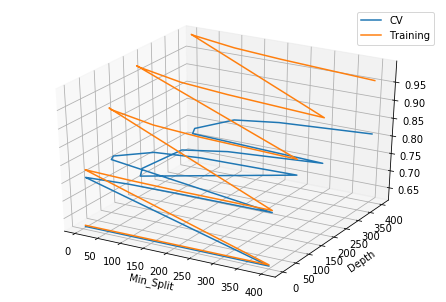

In [53]:
# ploting the roc curve with the hyper parameter
# in the plot the cross validation max accuracy may vary because we are using depth as well as min_split to find max_cv
#accuracy, but we are ploating the roc curve only with depth not with  min sample split
depth=[1, 10, 30, 100,300]
split=[5, 10, 100,200,400]
x_axis=[5, 10, 100,200,400,5, 10, 100,200,400,5,10,100,200,400,5,10,100,200,400,5,10,100,200,400]
z_axis=[1,1,1,1,1,10,10,10,10,10,100,100,100,100,100,200,200,200,200,200,400,400,400,400,400]
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(xs=x_axis, ys=z_axis,zs=roc_auc_cv,zdir=z_axis,label='CV')
ax.plot(xs=x_axis, ys=z_axis,zs=roc_auc_train,zdir=z_axis,label='Training')
plt.ylabel("Depth")
plt.xlabel("Min_Split")
plt.legend()
plt.show()

 AUC =  0.8282661694272756


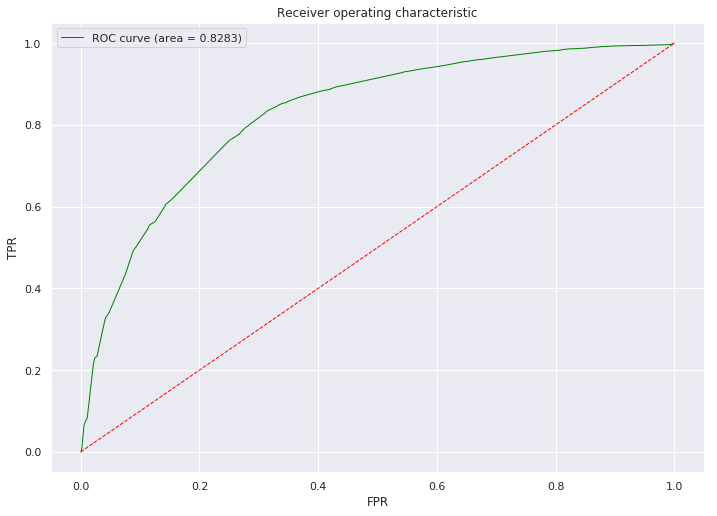

In [87]:
clf=tree.DecisionTreeClassifier(min_samples_split=400,max_depth=30)
clf.fit(final_train,y_train)
y_pred=clf.predict_proba(final_test)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
auc=metrics.auc(fpr,tpr)
print(' AUC = ',auc)
plt.figure()
plt.plot(fpr, tpr, color='green', lw=1, label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic')
plt.legend(loc="upper left")
plt.show()

OVER THE TEST DATA:
              precision    recall  f1-score   support

           0       0.59      0.37      0.45      4034
           1       0.89      0.95      0.92     21238

   micro avg       0.86      0.86      0.86     25272
   macro avg       0.74      0.66      0.69     25272
weighted avg       0.84      0.86      0.84     25272



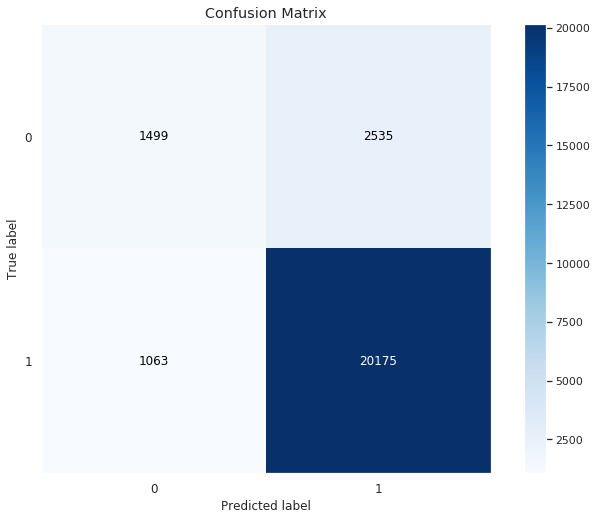

In [88]:
from sklearn.metrics import accuracy_score
print("OVER THE TEST DATA:")
import scikitplot.metrics as skplt
prediction=clf.predict(final_test)
print(metrics.classification_report(y_test,prediction))
skplt.plot_confusion_matrix(y_test,prediction)

OVER THE TRAINING DATA:
              precision    recall  f1-score   support

           0       0.69      0.44      0.54     12889
           1       0.90      0.96      0.93     67979

   micro avg       0.88      0.88      0.88     80868
   macro avg       0.80      0.70      0.73     80868
weighted avg       0.87      0.88      0.87     80868



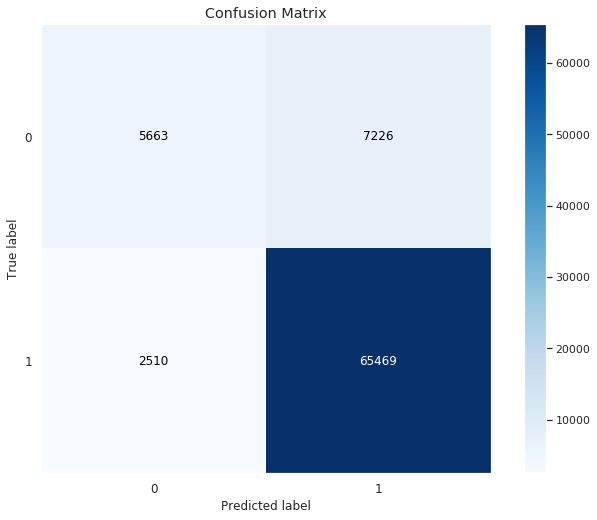

In [89]:
from sklearn.metrics import accuracy_score
print("OVER THE TRAINING DATA:")
import scikitplot.metrics as skplt
prediction=clf.predict(final_train)
print(metrics.classification_report(y_train,prediction))
skplt.plot_confusion_matrix(y_train,prediction)

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

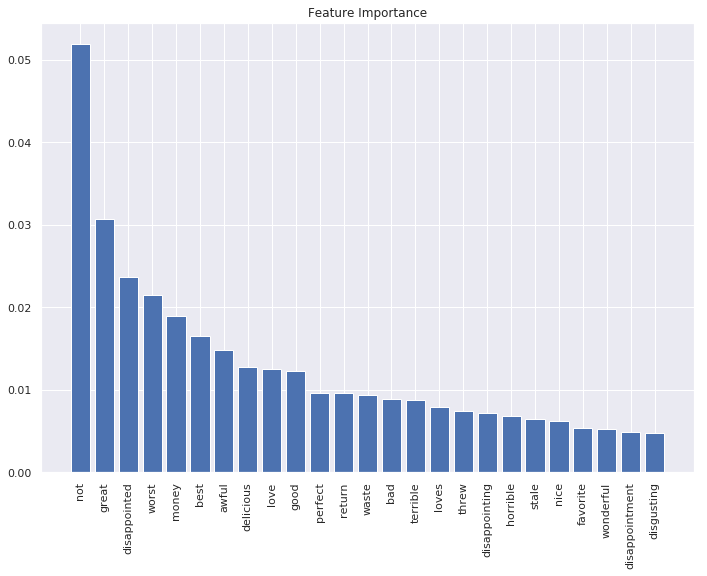

In [56]:

# Calculate feature importances from decision trees
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = count_vect.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names(

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

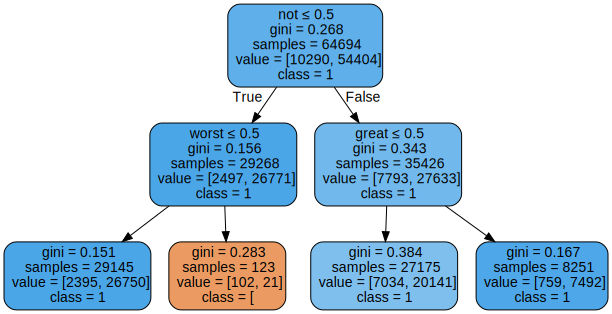

In [34]:
import graphviz # import the package to plot the decision tree
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth = 2,min_samples_split=400)  # depth of the tree = 3
clf.fit(final_train1,y_train1)                                            # training the model with final_train and y_train
dot_data = tree.export_graphviz(clf, out_file = None, 
                      feature_names = count_vect.get_feature_names(),  
                      class_names = str(list(y_train)),  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [58]:
# We have BOW in final_train, final_cv, final_test
from sklearn import tree
from sklearn.metrics import roc_auc_score
depth=[1, 10, 30, 100,300]
split=[5, 10, 100,200,400]
roc_auc_cv = []              # to store the cross validation accuracy on the cv dataset (final_cv)
roc_auc_train= []            # to store the training accuracy on the training dataset (final_train)
cv_acc=0
max_auc = 0
opt_sample_split = 0
opt_depth = 0
for d in depth:
    for s in split:
        clf = tree.DecisionTreeClassifier(max_depth = d,min_samples_split=s)
        clf.fit(final_tfidf_train,y_train)
        cv_prediction = clf.predict_proba(final_tfidf_cv)[:,1]
        train_prediction = clf.predict_proba(final_tfidf_train)[:,1]
        cv_auc = roc_auc_score(y_cv, cv_prediction)
        train_acc = roc_auc_score(y_train,train_prediction)
        if(max_auc < cv_auc):
            opt_depth = d
            opt_sample_split = s
            max_auc = cv_auc
        roc_auc_cv.append(cv_auc)
        roc_auc_train.append(train_acc)   
print("Various AUC_ROC socres over the cross validation data")
print(roc_auc_cv)
print("******************")
print("AUC score on the training data:")
print(roc_auc_train)
print("***************")
print("Max ROC_AUC Score :",max_auc)
print("Optimal_depth of the decision tree :",opt_depth)
print("Optimal min_sample_split in the decision tree :",opt_sample_split)

Various AUC_ROC socres over the cross validation data
[0.6216702537060244, 0.6216702537060244, 0.6216702537060244, 0.6216702537060244, 0.6216702537060244, 0.7415261695903463, 0.7417050043956935, 0.7478355431406458, 0.7488111843714158, 0.750352554403054, 0.7699942559227146, 0.7773594120911321, 0.8301022522484911, 0.838498470665751, 0.8478080827502184, 0.7072281475884843, 0.7213236852242639, 0.8033827864837859, 0.8347818773910305, 0.8487603576372644, 0.7292683267170379, 0.7484757245409533, 0.8053872050452797, 0.8277056834395077, 0.8417182776072835]
******************
AUC score on the training data:
[0.6248888068353513, 0.6248888068353513, 0.6248888068353513, 0.6248888068353513, 0.6248888068353513, 0.7625492815938576, 0.7624084694176164, 0.7582927403186134, 0.7572137262303755, 0.7556241768406271, 0.9067614372623514, 0.9027279588316177, 0.8850648062940752, 0.8767851548756636, 0.8693154545197677, 0.9898717683360455, 0.9873162830491762, 0.9661422305515889, 0.9522206511154253, 0.9384090209518

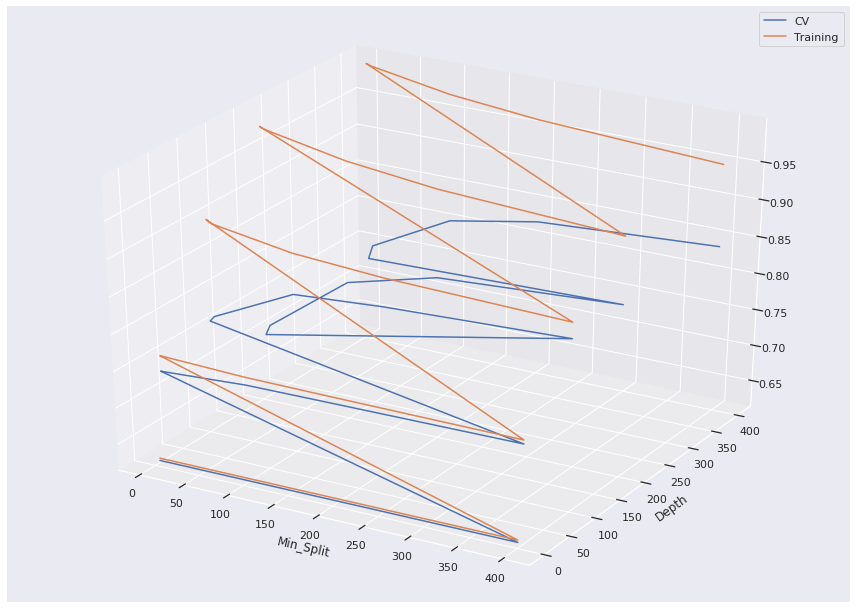

In [59]:
x_axis=[5, 10, 100,200,400,5, 10, 100,200,400,5,10,100,200,400,5,10,100,200,400,5,10,100,200,400]
z_axis=[1,1,1,1,1,10,10,10,10,10,100,100,100,100,100,200,200,200,200,200,400,400,400,400,400]
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(xs=x_axis, ys=z_axis,zs=roc_auc_cv,zdir=z_axis,label='CV')
ax.plot(xs=x_axis, ys=z_axis,zs=roc_auc_train,zdir=z_axis,label='Training')
plt.ylabel("Depth")
plt.xlabel("Min_Split")
plt.legend()
plt.show()

 AUC =  0.8452165912654201


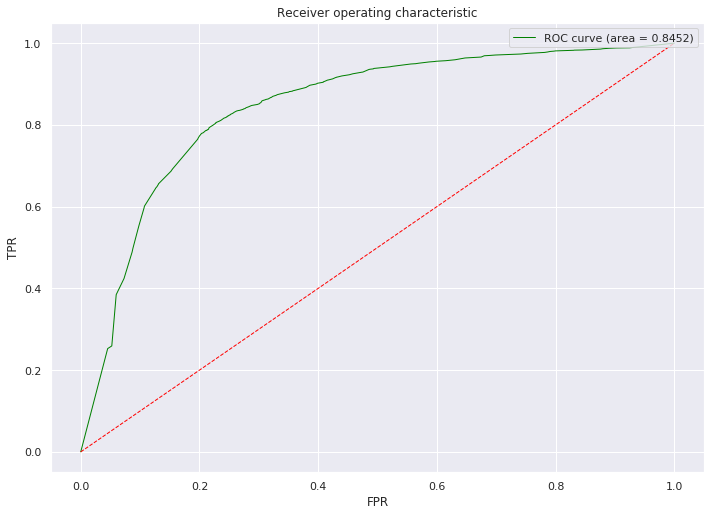

In [75]:
clf=tree.DecisionTreeClassifier(min_samples_split=400,max_depth=100)
clf.fit(final_tfidf_train,y_train)
y_pred=clf.predict_proba(final_tfidf_test)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
auc=metrics.auc(fpr,tpr)
print(' AUC = ',auc)
plt.figure()
plt.plot(fpr, tpr, color='green', lw=1, label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic')
plt.legend(loc="upper right")
plt.show()

              precision    recall  f1-score   support

           0       0.58      0.52      0.55      4034
           1       0.91      0.93      0.92     21238

   micro avg       0.86      0.86      0.86     25272
   macro avg       0.75      0.73      0.74     25272
weighted avg       0.86      0.86      0.86     25272



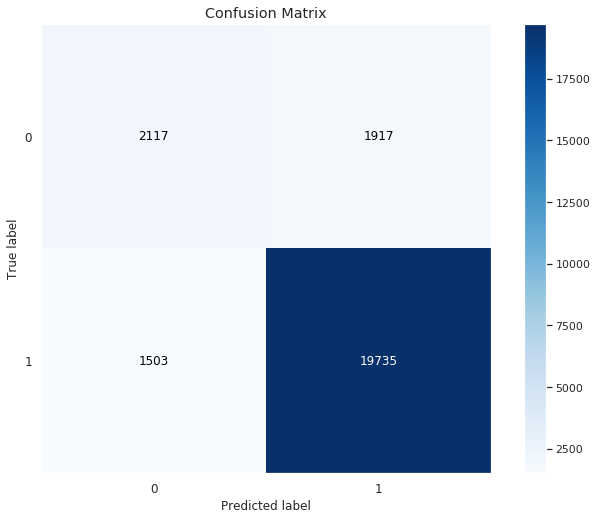

In [76]:
from sklearn.metrics import accuracy_score
prediction=clf.predict(final_tfidf_test)
print(metrics.classification_report(y_test,prediction))
skplt.plot_confusion_matrix(y_test,prediction)

OVER THE TRAINING DATA:
              precision    recall  f1-score   support

           0       0.72      0.64      0.68     12889
           1       0.93      0.95      0.94     67979

   micro avg       0.90      0.90      0.90     80868
   macro avg       0.83      0.80      0.81     80868
weighted avg       0.90      0.90      0.90     80868



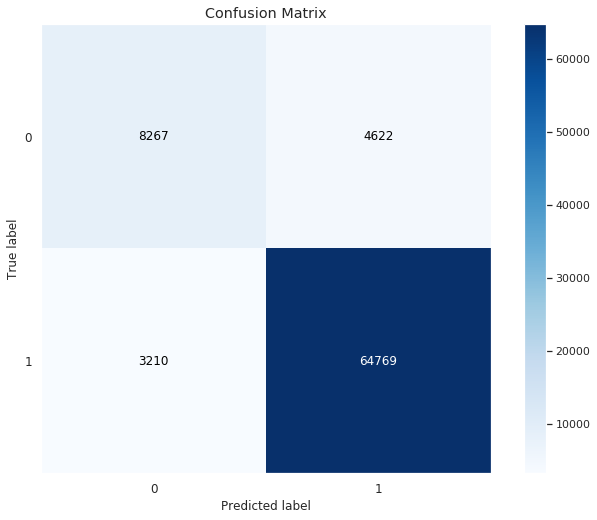

In [79]:
from sklearn.metrics import accuracy_score
print("OVER THE TRAINING DATA:")
prediction=clf.predict(final_tfidf_train)
print(metrics.classification_report(y_train,prediction))
skplt.plot_confusion_matrix(y_train,prediction)

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

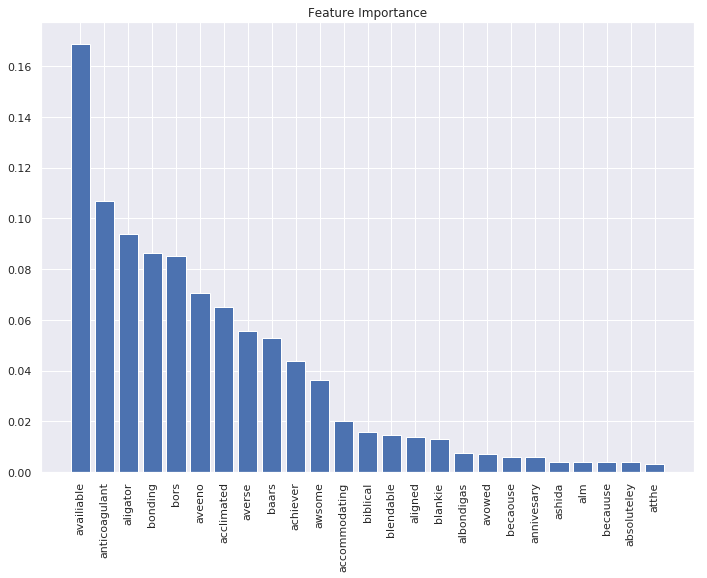

In [62]:
# Please write all the code with proper documentation
# Calculate feature importances from decision trees
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = count_vect.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names(

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

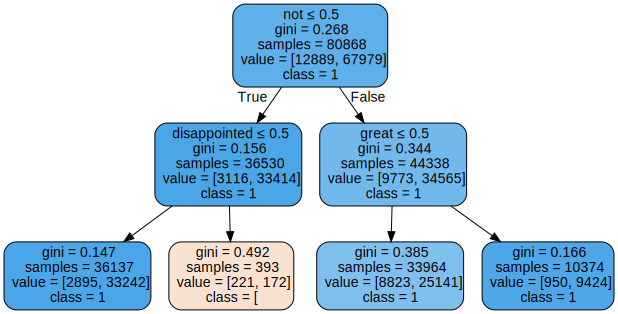

In [38]:
clf = tree.DecisionTreeClassifier(max_depth = 2,min_samples_split=400)  # training the classifier on opt depth
clf.fit(final_tfidf_train,y_train)                                     # tree iin batter manner
dot_data = tree.export_graphviz(clf, out_file = None, 
                      feature_names = count_vect_tfidf.get_feature_names(),  
                      class_names = str(list(y_train)),  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [64]:
# We have BOW in final_train, final_cv, final_test
from sklearn import tree
from sklearn.metrics import roc_auc_score
depth=[1, 10, 30, 100,300]
split=[5, 10, 100,200,400]
roc_auc_cv = []              # to store the cross validation accuracy on the cv dataset (final_cv)
roc_auc_train= []            # to store the training accuracy on the training dataset (final_train)
cv_acc=0
max_auc = 0
opt_sample_split = 0
opt_depth = 0
for d in depth:
    for s in split:
        clf = tree.DecisionTreeClassifier(max_depth = d,min_samples_split=s)
        clf.fit(x_train_w2v,y_train)
        cv_prediction = clf.predict_proba(x_cv_w2v)[:,1]
        train_prediction = clf.predict_proba(x_train_w2v)[:,1]
        cv_auc = roc_auc_score(y_cv, cv_prediction)
        train_acc = roc_auc_score(y_train,train_prediction)
        if(max_auc < cv_auc):
            opt_depth = d
            opt_sample_split = s
            max_auc = cv_auc
        roc_auc_cv.append(cv_auc)
        roc_auc_train.append(train_acc)   
print("Various AUC_ROC socres over the cross validation data")
print(roc_auc_cv)
print("******************")
print("AUC score on the training data:")
print(roc_auc_train)
print("***************")
print("Max ROC_AUC Score :",max_auc)
print("Optimal_depth of the decision tree :",opt_depth)
print("Optimal min_sample_split in the decision tree :",opt_sample_split)

Various AUC_ROC socres over the cross validation data
[0.6591518530629525, 0.6591518530629525, 0.6591518530629525, 0.6591518530629525, 0.6591518530629525, 0.8045600552833587, 0.8090996704226583, 0.8237765363620176, 0.8277341931997376, 0.8302074713174135, 0.6819586269218042, 0.6985364977211375, 0.8002017573295848, 0.8172161979368713, 0.8274975302197817, 0.68494749728311, 0.702678584122561, 0.7994017444964315, 0.8173021315446356, 0.8274402756254413, 0.6846098277581707, 0.700994232753833, 0.7993451387060013, 0.817598522096155, 0.8274431247208732]
******************
AUC score on the training data:
[0.6590232416170941, 0.6590232416170941, 0.6590232416170941, 0.6590232416170941, 0.6590232416170941, 0.9005001494376739, 0.8997611460178441, 0.8873079127498552, 0.8774940446659665, 0.864843399065758, 0.999536996526122, 0.9967001202859457, 0.9417340101942893, 0.9140601735783845, 0.8843912276875481, 0.9995887552185245, 0.9967864311868111, 0.9418417749875568, 0.9141825186868767, 0.8844904417393937, 

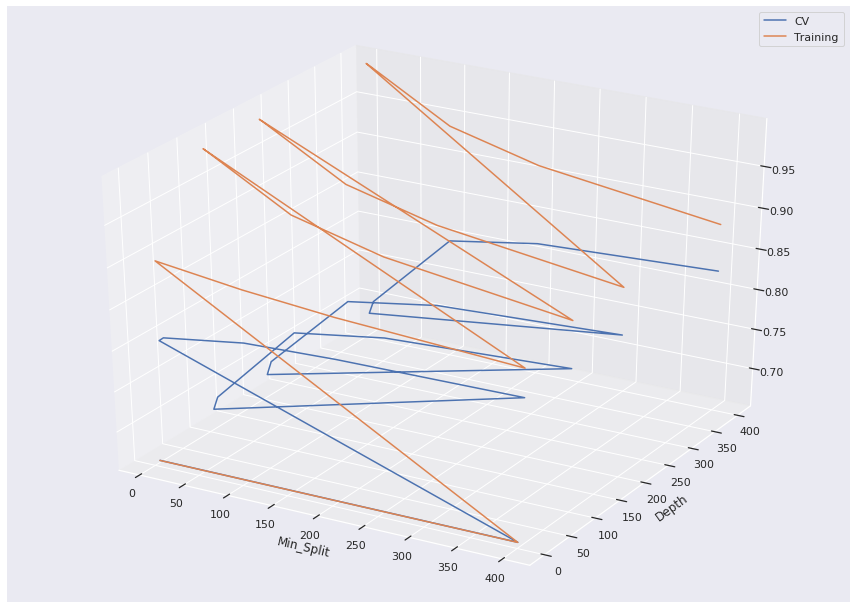

In [65]:
x_axis=[5, 10, 100,200,400,5, 10, 100,200,400,5,10,100,200,400,5,10,100,200,400,5,10,100,200,400]
z_axis=[1,1,1,1,1,10,10,10,10,10,100,100,100,100,100,200,200,200,200,200,400,400,400,400,400]
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(xs=x_axis, ys=z_axis,zs=roc_auc_cv,zdir=z_axis,label='CV')
ax.plot(xs=x_axis, ys=z_axis,zs=roc_auc_train,zdir=z_axis,label='Training')
plt.ylabel("Depth")
plt.xlabel("Min_Split")
plt.legend()
plt.show()

 AUC =  0.8274831555845377


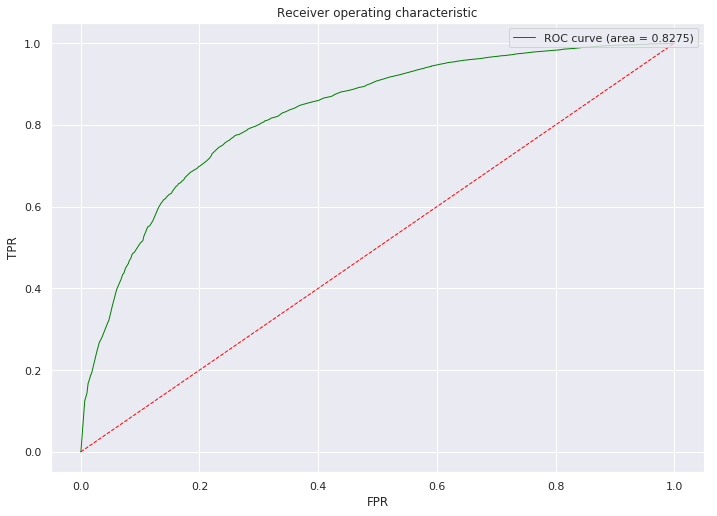

In [81]:
clf=tree.DecisionTreeClassifier(min_samples_split=400,max_depth=10)
clf.fit(x_train_w2v,y_train)
y_pred=clf.predict_proba(x_test_w2v)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
auc=metrics.auc(fpr,tpr)
print(' AUC = ',auc)
plt.figure()
plt.plot(fpr, tpr, color='green', lw=1, label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic')
plt.legend(loc="upper right")
plt.show()

FOR THE TEST DATA : 
              precision    recall  f1-score   support

           0       0.62      0.34      0.44      4034
           1       0.89      0.96      0.92     21238

   micro avg       0.86      0.86      0.86     25272
   macro avg       0.75      0.65      0.68     25272
weighted avg       0.84      0.86      0.84     25272



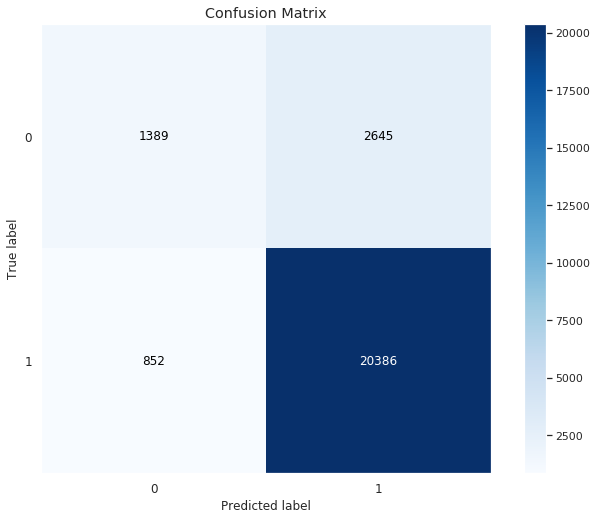

In [82]:
from sklearn.metrics import confusion_matrix
print("FOR THE TEST DATA : ")
prediction=clf.predict(x_test_w2v)
print(metrics.classification_report(y_test,prediction))
skplt.plot_confusion_matrix(y_test,prediction)

FOR THE TRAINING DATA: 
              precision    recall  f1-score   support

           0       0.67      0.37      0.48     12889
           1       0.89      0.96      0.93     67979

   micro avg       0.87      0.87      0.87     80868
   macro avg       0.78      0.67      0.70     80868
weighted avg       0.85      0.87      0.85     80868



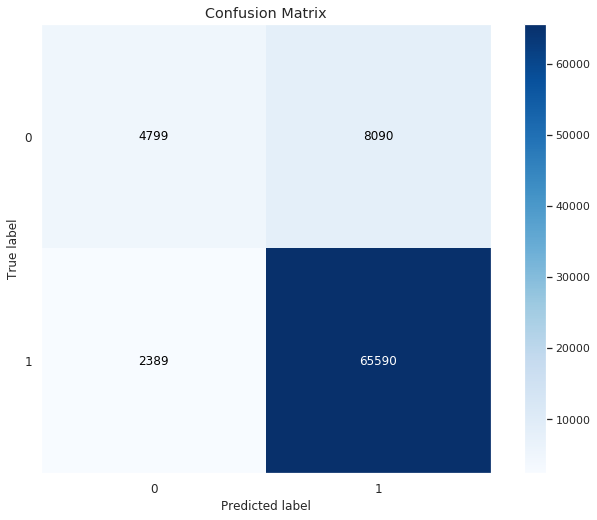

In [83]:
from sklearn.metrics import confusion_matrix
print("FOR THE TRAINING DATA: ")
prediction=clf.predict(x_train_w2v)
print(metrics.classification_report(y_train,prediction))
skplt.plot_confusion_matrix(y_train,prediction)

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [68]:
# We have BOW in final_train, final_cv, final_test
from sklearn import tree
from sklearn.metrics import roc_auc_score
depth=[1, 10, 30, 100,300]
split=[5, 10, 100,200,400]
roc_auc_cv = []              # to store the cross validation accuracy on the cv dataset (final_cv)
roc_auc_train= []            # to store the training accuracy on the training dataset (final_train)
cv_acc=0
max_auc = 0
opt_sample_split = 0
opt_depth = 0
for d in depth:
    for s in split:
        clf = tree.DecisionTreeClassifier(max_depth = d,min_samples_split=s)
        clf.fit(x_train_tfidf,y_train)
        cv_prediction = clf.predict_proba(x_cv_tfidf)[:,1]
        train_prediction = clf.predict_proba(x_train_tfidf)[:,1]
        cv_auc = roc_auc_score(y_cv, cv_prediction)
        train_acc = roc_auc_score(y_train,train_prediction)
        if(max_auc < cv_auc):
            opt_depth = d
            opt_sample_split = s
            max_auc = cv_auc
        roc_auc_cv.append(cv_auc)
        roc_auc_train.append(train_acc)   
print("Various AUC_ROC socres over the cross validation data")
print(roc_auc_cv)
print("******************")
print("AUC score on the training data:")
print(roc_auc_train)
print("***************")
print("Max ROC_AUC Score :",max_auc)
print("Optimal_depth of the decision tree :",opt_depth)
print("Optimal min_sample_split in the decision tree :",opt_sample_split)

Various AUC_ROC socres over the cross validation data
[0.6363380175847299, 0.6363380175847299, 0.6363380175847299, 0.6363380175847299, 0.6363380175847299, 0.7755230243394367, 0.7776292016823316, 0.7890116106186594, 0.790446125467167, 0.7881402105494688, 0.6592984545378022, 0.6763841789486187, 0.7622410303893734, 0.7815530642989875, 0.7883818100809159, 0.6639581172064076, 0.6802250792913601, 0.763520810206765, 0.7819153037459191, 0.7879818083658168, 0.6633758486073058, 0.6769784739274483, 0.7629251517994285, 0.7817961589003146, 0.7881943433626758]
******************
AUC score on the training data:
[0.633775334343434, 0.633775334343434, 0.633775334343434, 0.633775334343434, 0.633775334343434, 0.8780693456706394, 0.8773250008907116, 0.8652946429875483, 0.8548309333927133, 0.8395461829350482, 0.9994420726820987, 0.9961135105491081, 0.9287272790568053, 0.8946272874878225, 0.8613886324633411, 0.9995430820244218, 0.9963494052123326, 0.9290549909011928, 0.8951101686963472, 0.8615124310380906, 

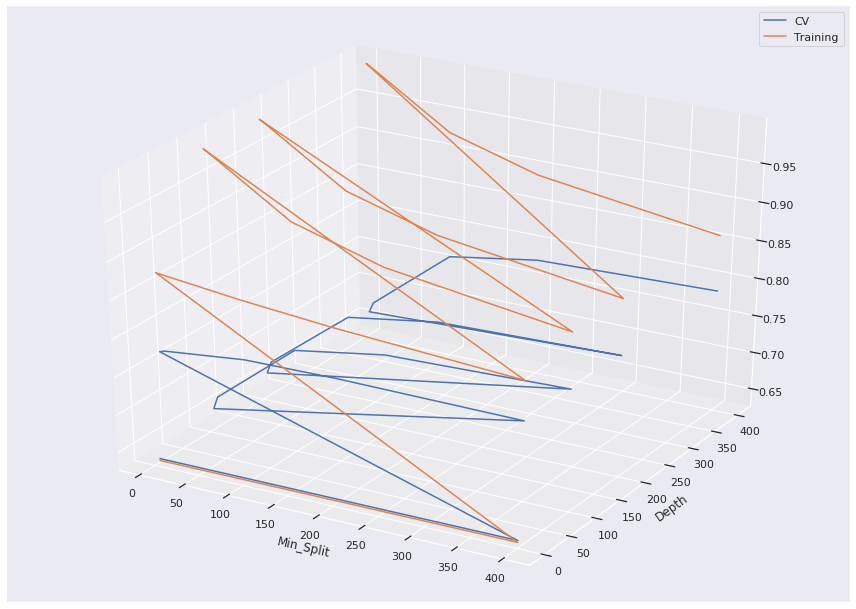

In [69]:
x_axis=[5, 10, 100,200,400,5, 10, 100,200,400,5,10,100,200,400,5,10,100,200,400,5,10,100,200,400]
z_axis=[1,1,1,1,1,10,10,10,10,10,100,100,100,100,100,200,200,200,200,200,400,400,400,400,400]
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(xs=x_axis, ys=z_axis,zs=roc_auc_cv,zdir=z_axis,label='CV')
ax.plot(xs=x_axis, ys=z_axis,zs=roc_auc_train,zdir=z_axis,label='Training')
plt.ylabel("Depth")
plt.xlabel("Min_Split")
plt.legend()
plt.show()

 AUC =  0.7946186695506502


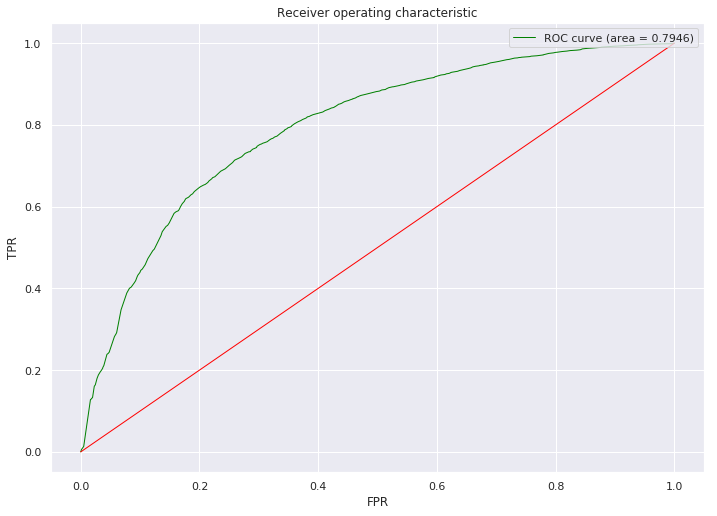

In [84]:
clf=tree.DecisionTreeClassifier(min_samples_split=200,max_depth=10)
clf.fit(x_train_tfidf,y_train)
y_pred=clf.predict_proba(x_test_tfidf)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
auc=metrics.auc(fpr,tpr)
print(' AUC = ',auc)
plt.figure()
plt.plot(fpr, tpr, color='green', lw=1, label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], color='red', lw=1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic')
plt.legend(loc="upper right")
plt.show()

FOR TEST DATA:
              precision    recall  f1-score   support

           0       0.57      0.28      0.37      4034
           1       0.88      0.96      0.92     21238

   micro avg       0.85      0.85      0.85     25272
   macro avg       0.72      0.62      0.64     25272
weighted avg       0.83      0.85      0.83     25272



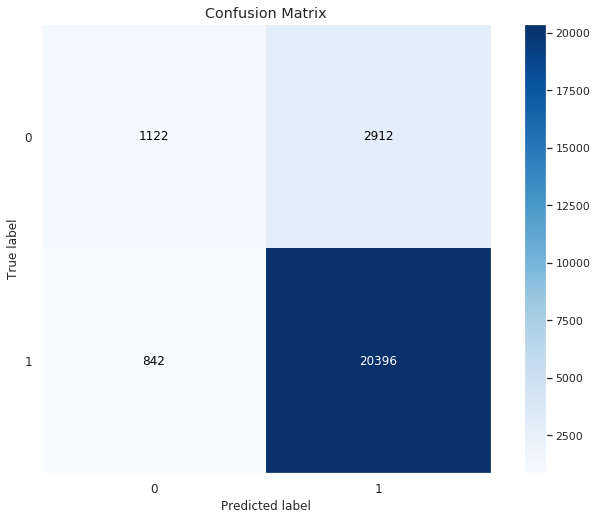

In [85]:
from sklearn.metrics import confusion_matrix
print("FOR TEST DATA:")
prediction=clf.predict(x_test_tfidf)
print(metrics.classification_report(y_test,prediction))
skplt.plot_confusion_matrix(y_test,prediction)

FOR TRAINING DATA:
              precision    recall  f1-score   support

           0       0.70      0.35      0.47     12889
           1       0.89      0.97      0.93     67979

   micro avg       0.87      0.87      0.87     80868
   macro avg       0.79      0.66      0.70     80868
weighted avg       0.86      0.87      0.85     80868



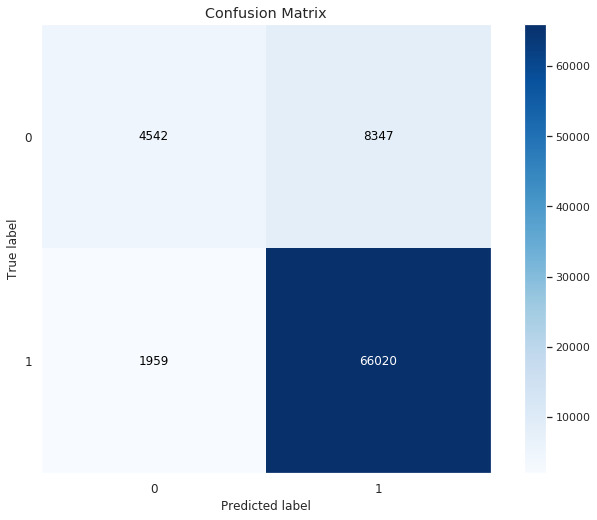

In [86]:
from sklearn.metrics import confusion_matrix
print("FOR TRAINING DATA:")
prediction=clf.predict(x_train_tfidf)
print(metrics.classification_report(y_train,prediction))
skplt.plot_confusion_matrix(y_train,prediction)

# [6] Conclusions

In [39]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = (["Vector_Rep_Type", "Optimal_Depth","Optimal_Split","Optimal_CV AUC", "AUC_ROC Score Test"])
x.add_row(["BOW", 30, 400, 0.8272892547616378,0.8282661694272756])
x.add_row(["tfidf", 100,400,0.8487603576372644,0.8452165912654201])
x.add_row(["avgw2v", 10,400,0.8302074713174135, 0.8274831555845377])
x.add_row(["tfidfw2v",10,200,0.790446125467167, 0.7946186695506502])
print(x)


+-----------------+---------------+---------------+--------------------+--------------------+
| Vector_Rep_Type | Optimal_Depth | Optimal_Split |   Optimal_CV AUC   | AUC_ROC Score Test |
+-----------------+---------------+---------------+--------------------+--------------------+
|       BOW       |       30      |      400      | 0.8272892547616378 | 0.8282661694272756 |
|      tfidf      |      100      |      400      | 0.8487603576372644 | 0.8452165912654201 |
|      avgw2v     |       10      |      400      | 0.8302074713174135 | 0.8274831555845377 |
|     tfidfw2v    |       10      |      200      | 0.790446125467167  | 0.7946186695506502 |
+-----------------+---------------+---------------+--------------------+--------------------+


-> By looking the above table, I can say that my model is performing best at depth 100 and split 400 for tfidf.
-> From the above ROC curve we can see that after a particular depth the accuracy of the model is not increasing, it is almost steady.
-> As the depth of the tree increases the train accuracy increases continuously, as my model start to overfit.
-> So from the above discussion I can say that tfidf based model is giving the best accuracy.